In [1]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'} 

warnings.simplefilter('ignore')
COLOR = 'orange'
rcParams['figure.figsize'] = 8, 5
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

In [2]:
import json


def load_data(fp):
    with open(fp) as fid:
        series = (pd.Series(json.loads(s)) for s in fid)
        return pd.concat(series, axis=1).T

renththerunway_fp = './renttherunway_final_data.json'
df = load_data(renththerunway_fp)
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"


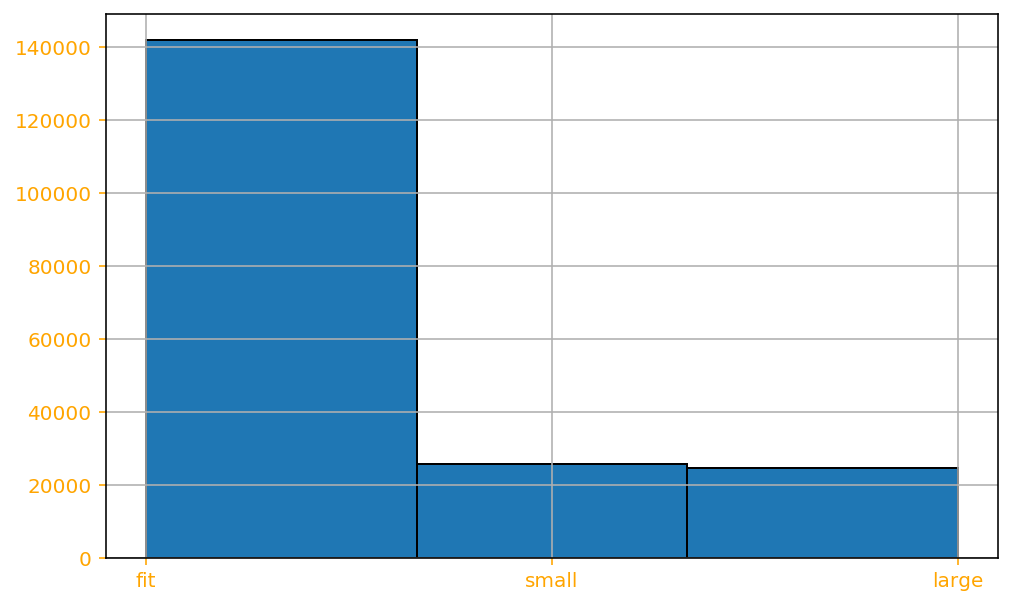

In [3]:
target_feature = 'fit'
n_classes = df[target_feature].unique().shape[0]
df[target_feature].hist(bins=n_classes, edgecolor='black');

Target variable has more observations in 'fit' class than the others. The dataset is unbalanced.

In [4]:
def check_nulls(data):
    for col in df:
        print(f'Column \'{col}\'. Is null - {data[col].isnull().sum()}')
        
check_nulls(df)

Column 'fit'. Is null - 0
Column 'user_id'. Is null - 0
Column 'bust size'. Is null - 18411
Column 'item_id'. Is null - 0
Column 'weight'. Is null - 29982
Column 'rating'. Is null - 82
Column 'rented for'. Is null - 10
Column 'review_text'. Is null - 0
Column 'body type'. Is null - 14637
Column 'review_summary'. Is null - 0
Column 'category'. Is null - 0
Column 'height'. Is null - 677
Column 'size'. Is null - 0
Column 'age'. Is null - 960
Column 'review_date'. Is null - 0


Columns 'bust size', 'weight', 'body type' contain the major of all missing values. Replacing them with most pobable values would make the dataset messy enough.

In [5]:
df[df['fit'] == 'fit'].isnull().sum()

fit                   0
user_id               0
bust size         13671
item_id               0
weight            22324
rating               63
rented for            9
review_text           0
body type         10903
review_summary        0
category              0
height              486
size                  0
age                 706
review_date           0
dtype: int64

As the dataset contains a lot of examples with target class 'fit', we may drop some having missing features.

In [6]:
to_drop = df[df['fit'] == 'fit'].isnull().any(axis=1)
n = to_drop.sum()
to_drop.shape, df.shape
df = df.drop(df[df['fit'] == 'fit'][to_drop].index, axis=0)
print(f'Dropped {n} examples')

Dropped 34325 examples


In [7]:
check_nulls(df)

Column 'fit'. Is null - 0
Column 'user_id'. Is null - 0
Column 'bust size'. Is null - 4740
Column 'item_id'. Is null - 0
Column 'weight'. Is null - 7658
Column 'rating'. Is null - 19
Column 'rented for'. Is null - 1
Column 'review_text'. Is null - 0
Column 'body type'. Is null - 3734
Column 'review_summary'. Is null - 0
Column 'category'. Is null - 0
Column 'height'. Is null - 191
Column 'size'. Is null - 0
Column 'age'. Is null - 254
Column 'review_date'. Is null - 0


Now let's augment the data with samples of minority classes.

In [8]:
n_repeat = 2
for i in range(n_repeat):
    df = df.append(df[((df['fit'] == 'large') | (df['fit'] == 'small'))].copy(), ignore_index=True)

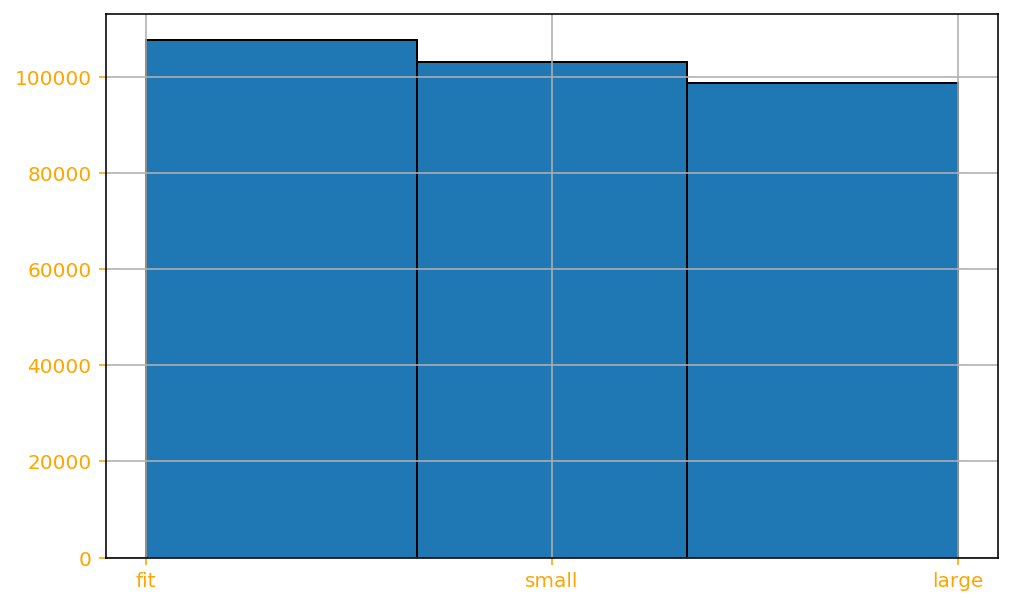

In [9]:
df[target_feature].hist(bins=n_classes, edgecolor='black');

In [10]:
cleaned_df = df.copy()
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309677 entries, 0 to 309676
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   fit             309677 non-null  object
 1   user_id         309677 non-null  object
 2   bust size       290717 non-null  object
 3   item_id         309677 non-null  object
 4   weight          279045 non-null  object
 5   rating          309601 non-null  object
 6   rented for      309673 non-null  object
 7   review_text     309677 non-null  object
 8   body type       294741 non-null  object
 9   review_summary  309677 non-null  object
 10  category        309677 non-null  object
 11  height          308913 non-null  object
 12  size            309677 non-null  object
 13  age             308661 non-null  object
 14  review_date     309677 non-null  object
dtypes: object(15)
memory usage: 35.4+ MB


All the columns were read as objects, so we need to convert them to their accurate datetypes.

In [11]:
def feet_to_meters(s):
    feet, inches = map(int, s.replace("'", '').replace("\"", '').split())
    return feet * 0.3048 + inches * 0.0254

def pounds_to_kilos(s):
    return int(s.replace('lbs', '')) * 0.45359237

cleaned_df['height'] = (cleaned_df['height']
                        .fillna("0' 0\"")
                        .apply(feet_to_meters))
cleaned_df['height'][cleaned_df['height'] == 0] = cleaned_df['height'].median()

cleaned_df['weight'] = (cleaned_df['weight']
                        .fillna('0lbs')
                        .apply(pounds_to_kilos))
cleaned_df['weight'][cleaned_df['weight'] == 0.0] = cleaned_df['weight'].median()

cleaned_df['user_id'] = pd.to_numeric(cleaned_df['user_id'])
cleaned_df['bust size'] = cleaned_df['bust size'].fillna(cleaned_df['bust size'].value_counts().index[0])
cleaned_df['body type'] = cleaned_df['body type'].fillna(cleaned_df['body type'].value_counts().index[0])
cleaned_df['item_id'] = pd.to_numeric(cleaned_df['item_id'])
cleaned_df['size'] = pd.to_numeric(cleaned_df['size'])

cleaned_df['age'] = pd.to_numeric(cleaned_df['age'])
cleaned_df['age'] = cleaned_df['age'].fillna(cleaned_df['age'].median())

cleaned_df['rating'] = pd.to_numeric(cleaned_df['rating'])
cleaned_df['rating'] = cleaned_df['rating'].fillna(cleaned_df['rating'].median())

cleaned_df['review_date'] = pd.to_datetime(cleaned_df['review_date'], format='%B %d, %Y')
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309677 entries, 0 to 309676
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fit             309677 non-null  object        
 1   user_id         309677 non-null  int64         
 2   bust size       309677 non-null  object        
 3   item_id         309677 non-null  int64         
 4   weight          309677 non-null  float64       
 5   rating          309677 non-null  float64       
 6   rented for      309673 non-null  object        
 7   review_text     309677 non-null  object        
 8   body type       309677 non-null  object        
 9   review_summary  309677 non-null  object        
 10  category        309677 non-null  object        
 11  height          309677 non-null  float64       
 12  size            309677 non-null  int64         
 13  age             309677 non-null  float64       
 14  review_date     309677 non-null  dat

Renaming columns to clarify what they correspond to.

In [12]:
col_mapper = {
    'bust size': 'bust_size',
    'weight': 'usr_weight_kg',
    'rating': 'review_rating',
    'rented for': 'rented_for',
    'body type': 'body_type',
    'category': 'product_category',
    'height': 'usr_height_meters',
    'size': 'product_size',
    'age': 'usr_age',
}
cleaned_df.rename(col_mapper, axis=1, inplace=True)

In [13]:
cleaned_df.head()

,fit,user_id,bust_size,item_id,usr_weight_kg,review_rating,rented_for,review_text,body_type,review_summary,product_category,usr_height_meters,product_size,usr_age,review_date
0,fit,420272,34d,2260466,62.142155,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,1.7272,14,28.0,2016-04-20
1,fit,273551,34b,153475,59.874193,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,1.6764,12,36.0,2013-06-18
2,fit,909926,34c,126335,61.234970,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,1.6510,8,34.0,2014-02-12
3,fit,151944,34b,616682,65.770894,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,1.7526,12,27.0,2016-09-26
4,fit,734848,32b,364092,62.595747,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,1.7272,8,45.0,2016-04-30


Now we should handle the categorial features left. I'll start with the 'bust_size' column.

In [14]:
import re


def parse_bust_size(s):
    m = re.match(r'(\d+)([A-Za-z])(\+?)', s)
    if m:
        return pd.Series(data=[int(m.group(1)), m.group(2).lower()])
    return []

mapper = {
    0: 'bust_size_num', 
    1: 'bust_size_cat'
}
temp_df = cleaned_df['bust_size'].apply(parse_bust_size).rename(mapper, axis=1)
temp_df['bust_size_num'] = pd.to_numeric(temp_df['bust_size_num'])
cleaned_df = cleaned_df.join(temp_df)
cleaned_df.drop(['bust_size'], axis=1, inplace=True)
cleaned_df.head()

,fit,user_id,item_id,usr_weight_kg,review_rating,rented_for,review_text,body_type,review_summary,product_category,usr_height_meters,product_size,usr_age,review_date,bust_size_num,bust_size_cat
0,fit,420272,2260466,62.142155,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,1.7272,14,28.0,2016-04-20,34,d
1,fit,273551,153475,59.874193,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,1.6764,12,36.0,2013-06-18,34,b
2,fit,909926,126335,61.234970,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,1.6510,8,34.0,2014-02-12,34,c
3,fit,151944,616682,65.770894,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,1.7526,12,27.0,2016-09-26,34,b
4,fit,734848,364092,62.595747,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,1.7272,8,45.0,2016-04-30,32,b


To handle the column 'bust_size' I converted it into two new features, one of which is oridinal ('bust_size_cat'), so we can easily handle it using label encoding.

In [15]:
unique_cats = sorted(cleaned_df['bust_size_cat'].unique().tolist())
mapper = {unique_cats[i]:i+1 for i in range(len(unique_cats))}
cleaned_df['bust_size_cat'] = cleaned_df['bust_size_cat'].map(mapper)

The target feature is ordinal, so I treat it the same way.

In [16]:
mapper = {
    'small': -1,
    'fit': 0,
    'large': 1,
}
cleaned_df[target_feature] = cleaned_df[target_feature].map(mapper)
cleaned_df.head()

,fit,user_id,item_id,usr_weight_kg,review_rating,rented_for,review_text,body_type,review_summary,product_category,usr_height_meters,product_size,usr_age,review_date,bust_size_num,bust_size_cat
0,0,420272,2260466,62.142155,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,1.7272,14,28.0,2016-04-20,34,4
1,0,273551,153475,59.874193,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,1.6764,12,36.0,2013-06-18,34,2
2,0,909926,126335,61.234970,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,1.6510,8,34.0,2014-02-12,34,3
3,0,151944,616682,65.770894,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,1.7526,12,27.0,2016-09-26,34,2
4,0,734848,364092,62.595747,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,1.7272,8,45.0,2016-04-30,32,2


,fit,usr_weight_kg,review_rating,usr_height_meters,product_size,usr_age,bust_size_num,bust_size_cat
fit,1.000000,-0.027039,0.035288,-0.024587,-0.169572,-0.024156,-0.022500,-0.012785
usr_weight_kg,-0.027039,1.000000,-0.005510,0.355565,0.732249,0.063322,0.572700,0.262860
review_rating,0.035288,-0.005510,1.000000,0.003664,-0.034203,-0.038369,-0.016221,-0.006251
usr_height_meters,-0.024587,0.355565,0.003664,1.000000,0.221866,-0.004923,0.149570,0.011947
product_size,-0.169572,0.732249,-0.034203,0.221866,1.000000,0.154009,0.605686,0.279057
usr_age,-0.024156,0.063322,-0.038369,-0.004923,0.154009,1.000000,0.169045,0.061963
bust_size_num,-0.022500,0.572700,-0.016221,0.149570,0.605686,0.169045,1.000000,0.123812
bust_size_cat,-0.012785,0.262860,-0.006251,0.011947,0.279057,0.061963,0.123812,1.000000


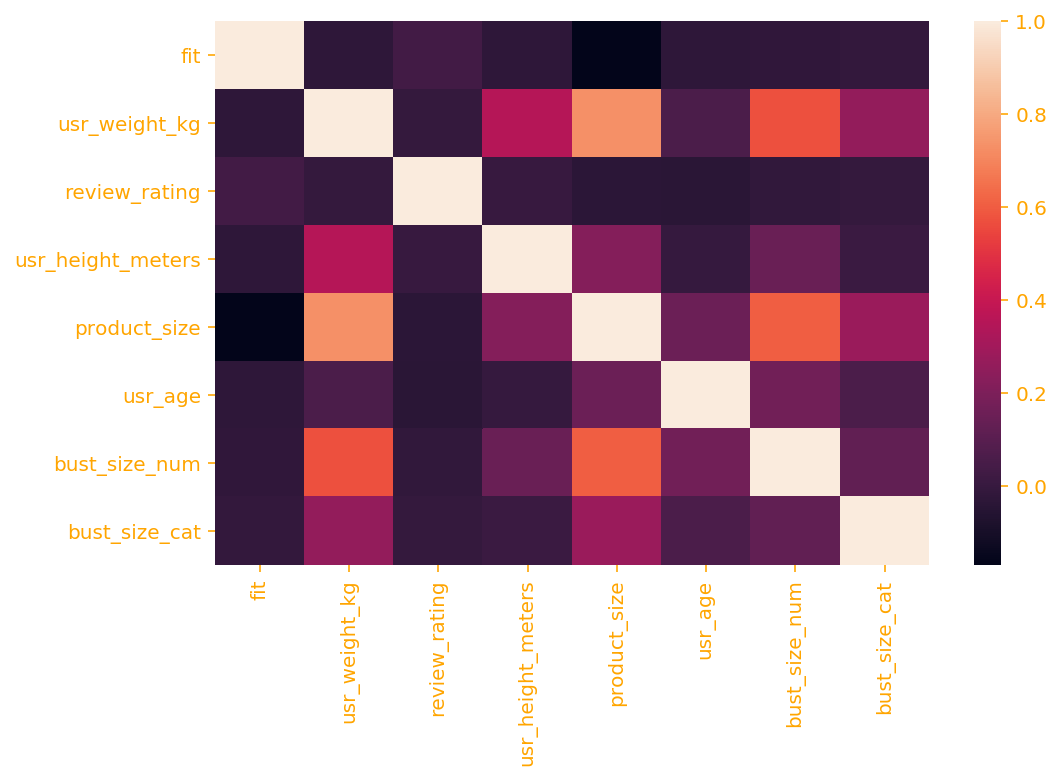

In [17]:
from sklearn.preprocessing import scale


numeric_dtypes = {'int64', 'float64'}
numeric_features = [c for c in cleaned_df.columns if str(cleaned_df[c].dtype) in numeric_dtypes]
numeric_features.remove('user_id')
numeric_features.remove('item_id')

cleaned_df_scaled = cleaned_df[numeric_features].copy()
cleaned_df_scaled = pd.DataFrame(scale(cleaned_df_scaled), columns=numeric_features)

corr_matrix = cleaned_df_scaled.corr()
sns.heatmap(corr_matrix)
corr_matrix

Product size feature correlates well with the target feature

In [18]:
print('Pairs of columns that have correlation greater than 0.5: ')
lim = 0.5
corr_cols = []
for i in range(corr_matrix.shape[0]):
    for j in range(i + 1, corr_matrix.shape[1]):
        if corr_matrix.iloc[i, j] > lim:
            pair = corr_matrix.columns[i], corr_matrix.columns[j]
            corr_cols.append(pair)
            print('({}, {})'.format(*pair))
            
print('These columns are to be inspected more closely')
corr_cols

Pairs of columns that have correlation greater than 0.5: 
(usr_weight_kg, product_size)
(usr_weight_kg, bust_size_num)
(product_size, bust_size_num)
These columns are to be inspected more closely


[('usr_weight_kg', 'product_size'),
 ('usr_weight_kg', 'bust_size_num'),
 ('product_size', 'bust_size_num')]

<Figure size 576x360 with 0 Axes>

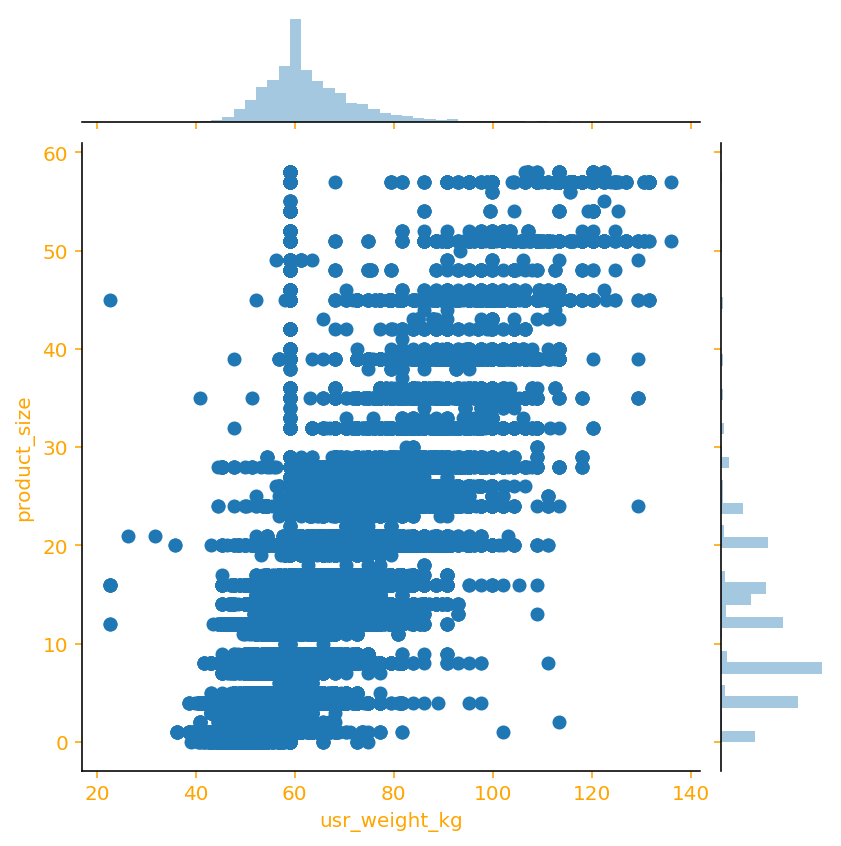

<Figure size 576x360 with 0 Axes>

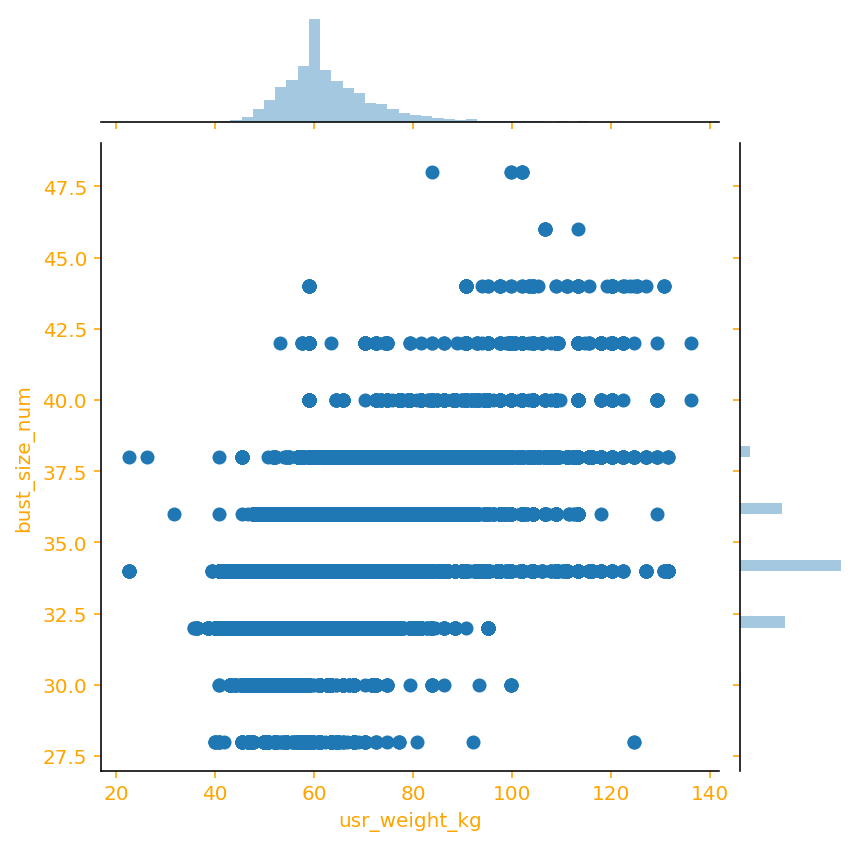

<Figure size 576x360 with 0 Axes>

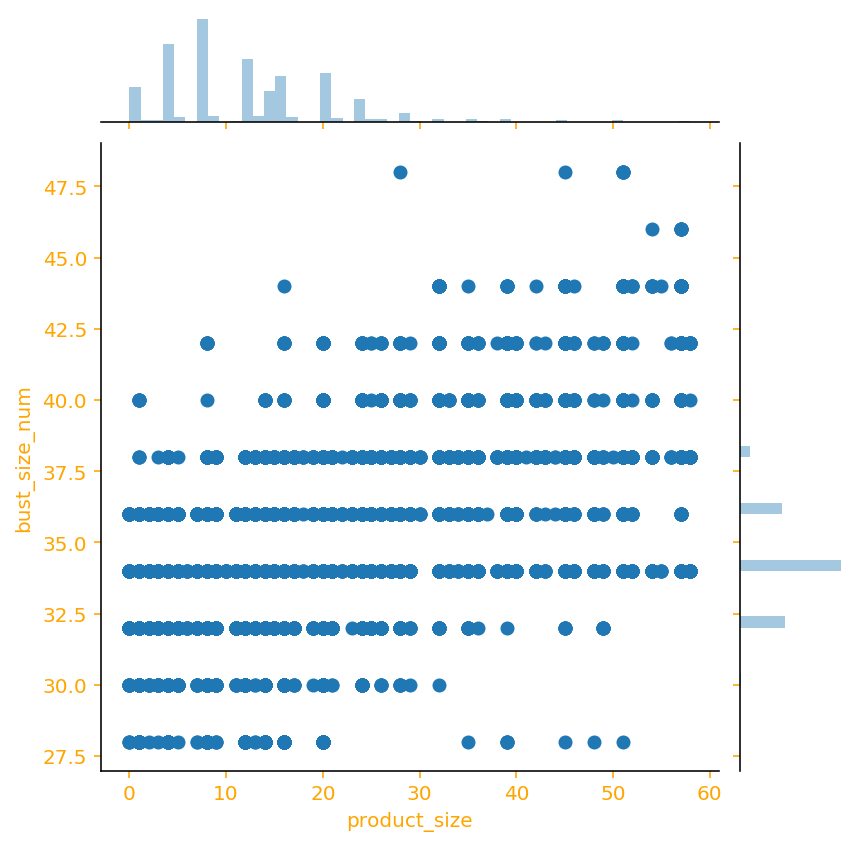

In [19]:
for x, y in corr_cols:
    plt.figure()
    sns.jointplot(x=x, y=y, data=cleaned_df)

plt.show()

1) Obviously, users of different weight categories (20-40kg, 40-60kg, etc) choose product sizes of some particular ranges (0-5, 5-10, etc respectively). Therefore, these two features can be used interchangeably. <br> <br>
2) In addition, users might have different bust sizes despite different weight categories. <br> <br>
3) Analogously, relationship between product sizes and bust sizes is the same as in (2) (consequence from (1))

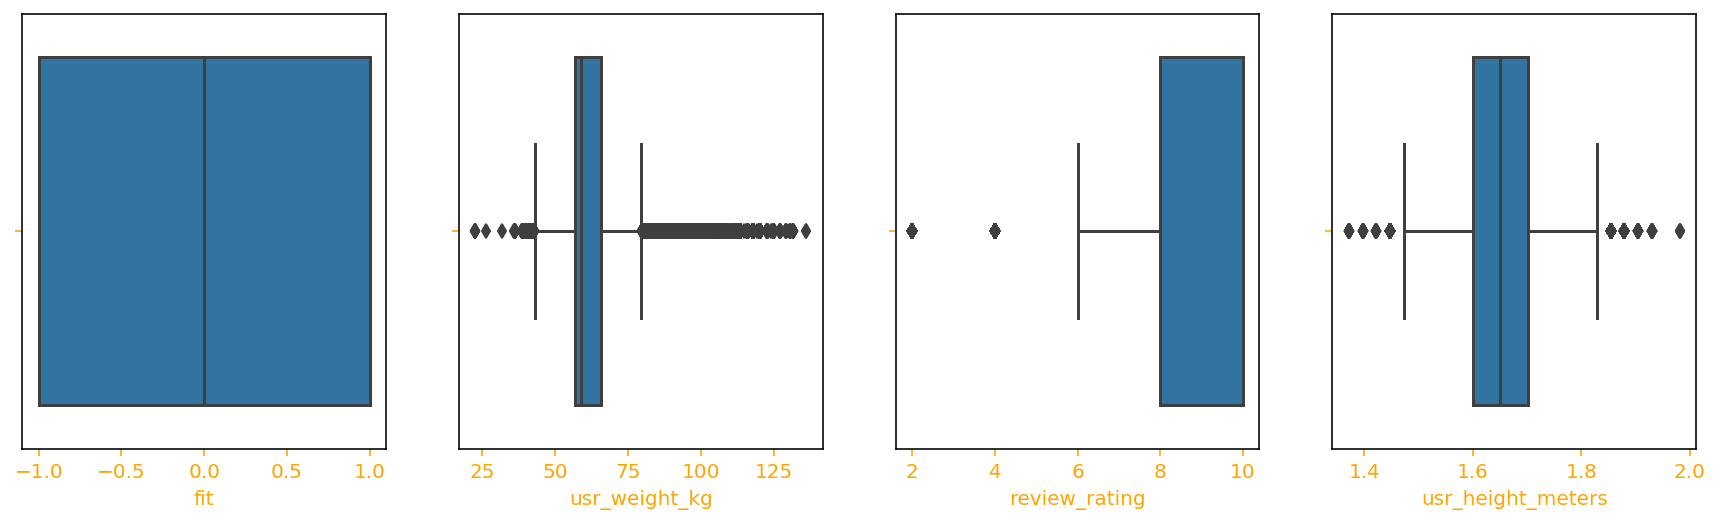

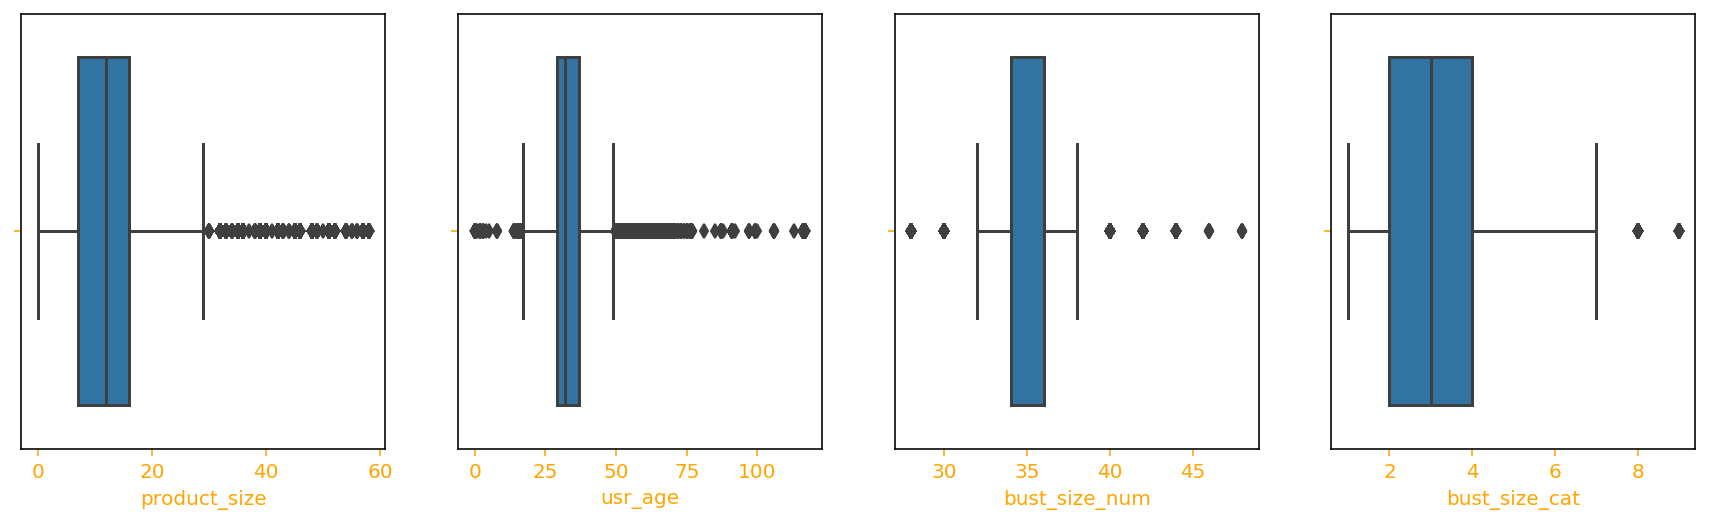

In [20]:
def draw_boxplots(cols, data, per_line=4):
    n = len(cols)
    per_line = 4
    for i in range(0, n, per_line):
        n_plots = per_line if n - i >= per_line else n % per_line
        fig, axes = plt.subplots(1, n_plots)
        plt.subplots_adjust(wspace=0.2)
        fig.set_figwidth(15)
        fig.set_figheight(4)
        for j in range(n_plots):
            sns.boxplot(data[cols[i + j]], ax=axes[j])
        plt.show()
        
draw_boxplots(numeric_features, cleaned_df)

Colomns 'usr_weight_kg', 'product_size' and 'usr_age' contain a lot of outliers. I'll fix 

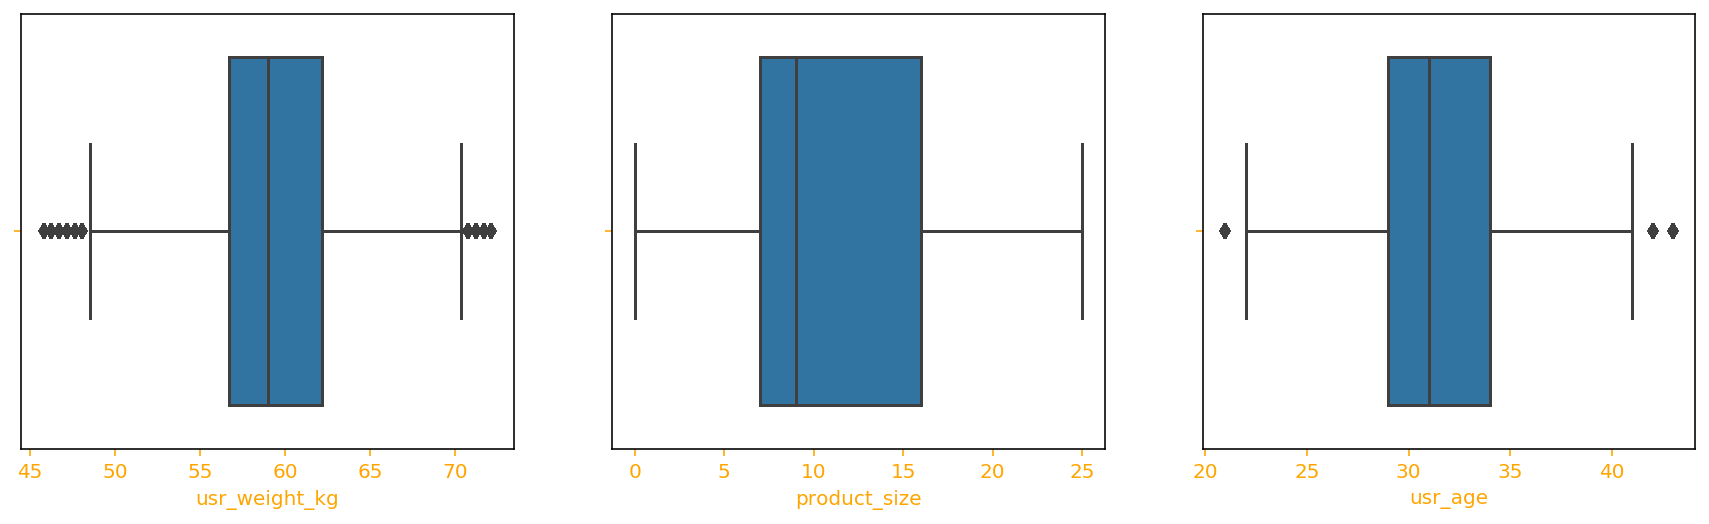

In [21]:
cols_with_outliers = ['usr_weight_kg', 'product_size', 'usr_age']

for c in cols_with_outliers:
    q1, q2, q3 = np.percentile(cleaned_df[c], [25, 50, 75])
    median = q2
    std = 0.7413 * (q3 - q1)
    query_result = cleaned_df.query(f'({c} > @median - 2 * @std) & ({c} < @median + 2 * @std)')[c]
    cleaned_df[c] = query_result
    cleaned_df[c] = cleaned_df[c].fillna(cleaned_df[c].median())
    
draw_boxplots(cols_with_outliers, cleaned_df)

Now based on the weight and height of a person we can calculate their BMI(body mass index) and use it as a feature instead. <br>
$ BMI = w /h^2 (kg/m^2)$

In [22]:
cleaned_df['BMI'] = cleaned_df['usr_weight_kg'] / np.power(cleaned_df['usr_height_meters'], 2)
cleaned_df.drop(['usr_weight_kg', 'usr_height_meters'], axis=1, inplace=True)

In [23]:
numeric_features.append('BMI')
numeric_features.remove('usr_weight_kg')
numeric_features.remove('usr_height_meters')

,fit,review_rating,product_size,usr_age,bust_size_num,bust_size_cat,BMI
fit,1.000000,0.035288,-0.205711,0.002780,-0.022500,-0.012785,-0.015711
review_rating,0.035288,1.000000,-0.025558,-0.054880,-0.016221,-0.006251,0.004006
product_size,-0.205711,-0.025558,1.000000,0.083525,0.456925,0.245172,0.276198
usr_age,0.002780,-0.054880,0.083525,1.000000,0.113600,0.042585,0.032627
bust_size_num,-0.022500,-0.016221,0.456925,0.113600,1.000000,0.123812,0.179609
bust_size_cat,-0.012785,-0.006251,0.245172,0.042585,0.123812,1.000000,0.146396
BMI,-0.015711,0.004006,0.276198,0.032627,0.179609,0.146396,1.000000


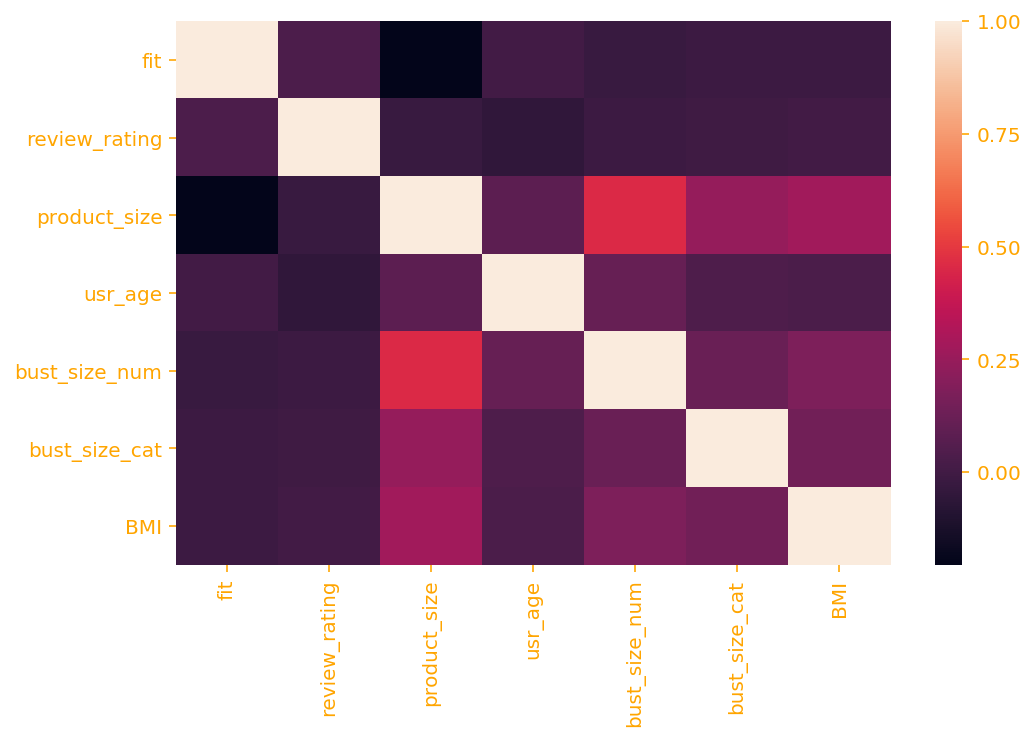

In [24]:
cleaned_df_scaled = cleaned_df[numeric_features].copy()
cleaned_df_scaled = pd.DataFrame(scale(cleaned_df_scaled), columns=numeric_features)

corr_matrix = cleaned_df_scaled.corr()
sns.heatmap(corr_matrix)
corr_matrix

Still we have very low 

In [25]:
print(df['category'].value_counts().index)
df['category'].value_counts().values
# select top 5 categories and send the rest to 6th 'others' then onehot the result

Index(['dress', 'gown', 'sheath', 'shift', 'jumpsuit', 'top', 'maxi', 'romper',
       'jacket', 'mini', 'skirt', 'coat', 'sweater', 'shirtdress', 'blazer',
       'blouse', 'pants', 'down', 'vest', 'shirt', 'cardigan', 'frock',
       'culottes', 'tank', 'tunic', 'sweatshirt', 'bomber', 'pant', 'leggings',
       'suit', 'print', 'cape', 'pullover', 'culotte', 'trouser', 'legging',
       'midi', 'poncho', 'peacoat', 'kimono', 'knit', 'kaftan', 'turtleneck',
       'hoodie', 'trench', 'tight', 'parka', 'ballgown', 'trousers', 'tee',
       't-shirt', 'skort', 'blouson', 'jeans', 'cami', 'duster', 'for',
       'caftan', 'overalls', 'skirts', 'jogger', 'combo', 'henley',
       'sweatershirt', 'buttondown', 'overcoat', 'crewneck', 'sweatpants'],
      dtype='object')


array([155611,  63159,  30139,   9530,   8243,   8073,   5321,   5085,
         4194,   2846,   2734,   2038,   1982,   1285,   1229,   1034,
          839,    819,    583,    540,    462,    371,    344,    320,
          313,    217,    210,    183,    171,    159,    136,    128,
          119,    113,    111,    102,     92,     88,     78,     68,
           67,     55,     55,     41,     38,     38,     32,     31,
           29,     28,     25,     24,     21,     20,     15,     15,
           12,     10,      9,      8,      7,      7,      7,      7,
            4,      1,      1,      1], dtype=int64)

In [26]:
cleaned_df[numeric_features].head()

,fit,review_rating,product_size,usr_age,bust_size_num,bust_size_cat,BMI
0,0,10.0,14.0,28.0,34,4,20.830565
1,0,10.0,12.0,36.0,34,2,21.305139
2,0,8.0,8.0,34.0,34,3,22.464945
3,0,10.0,12.0,27.0,34,2,21.412537
4,0,8.0,8.0,31.0,32,2,20.982613


fit,-1,0,1
product_category,,,
ballgown,23.777067,22.295385,22.777646
blazer,21.370406,21.391835,21.540064
blouse,21.795896,21.621447,21.485498
blouson,21.399360,21.904928,20.384858
bomber,21.670786,21.540025,21.374453
...,...,...,...
trouser,21.991753,22.098005,23.848537
trousers,20.627392,20.528719,0.000000
tunic,21.970709,21.724400,21.726135


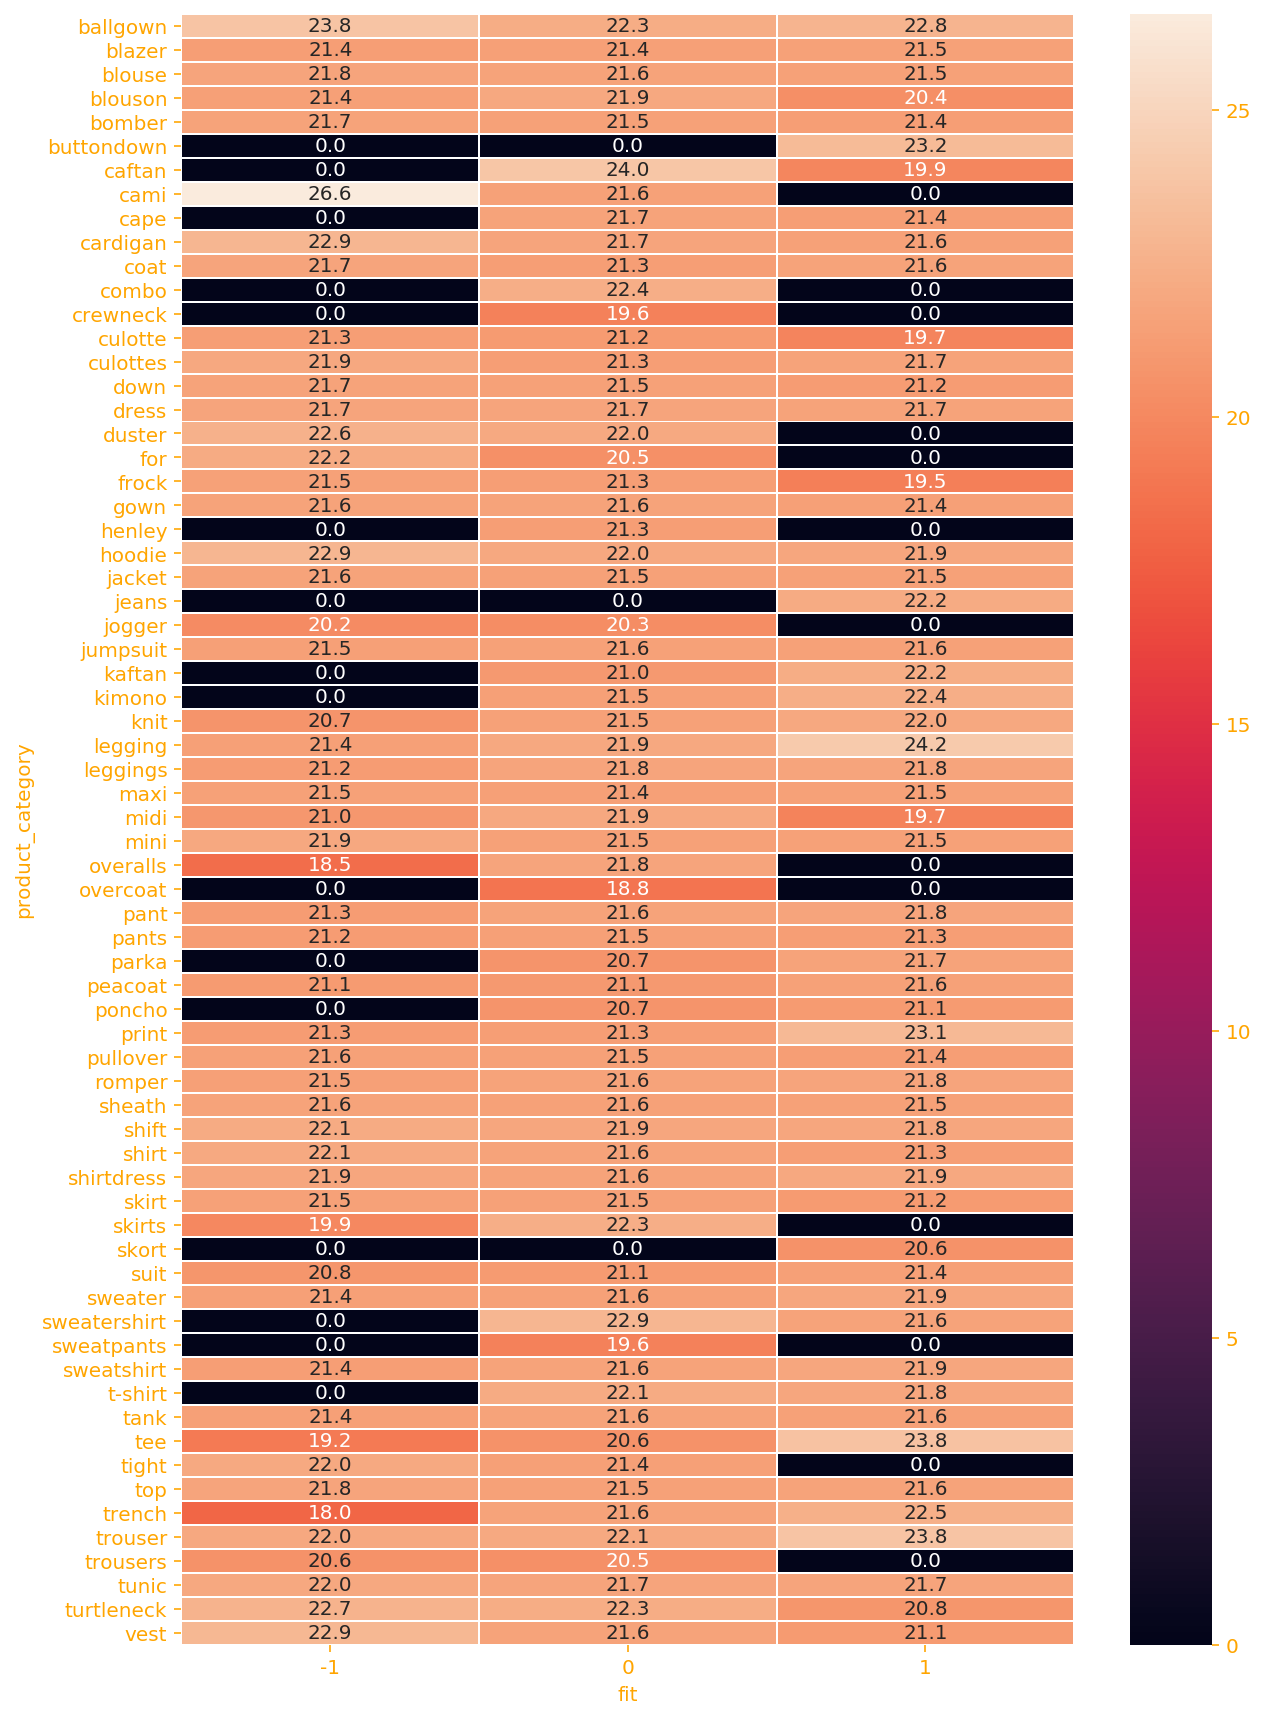

In [147]:
cat_features = ['fit', 'rented_for', 'product_category', 'body_type']

product_category_fits = cleaned_df.pivot_table(
                        index='product_category', 
                        columns='fit', 
                        values='BMI', 
                        ).fillna(0).applymap(float)
plt.figure(figsize=(10, 15))
sns.heatmap(product_category_fits, annot=True, fmt=".1f", linewidths=.5)
product_category_fits

In [148]:
from sklearn.model_selection import train_test_split


X = cleaned_df[numeric_features].drop(['fit'], axis=1).values.astype('float32')
y = cleaned_df[target_feature].astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.4, shuffle=True)

print(f'Samples for training: {X_train.shape[0]}')
# print(f'Samples for validation: {X_val.shape[0]}')
print(f'Samples for testing: {X_test.shape[0]}')

Samples for training: 263225
Samples for testing: 46452


In [149]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [150]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer


scorer = make_scorer(accuracy_score)
ensemble_models = [RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier]
n_estimators = 10
for model in ensemble_models:
    clf = model(n_estimators=n_estimators)
    scores = cross_val_score(clf, X_train_scaled, y_train, scoring='accuracy', cv=5)
    print(f"Scores: {', '.join(map(lambda n: str(round(n, 3)), scores))}. Mean: {scores.mean()}")

Scores: 0.736, 0.735, 0.737, 0.738, 0.737. Mean: 0.7367613394968844
Scores: 0.734, 0.734, 0.734, 0.736, 0.736. Mean: 0.7347744469480143
Scores: 0.478, 0.48, 0.482, 0.483, 0.482. Mean: 0.48085861136478825


In [151]:
from sklearn.cluster import KMeans, MeanShift


c = KMeans(3, max_iter=500)
c.fit(X_train_scaled, y_train)
preds = c.predict(scaler.transform(X_test))
print(f'KMeans score: {accuracy_score(y_test, preds)}')

KMeans score: 0.3430207526048394


In [152]:
from sklearn.model_selection import GridSearchCV


params = {
    'n_estimators': [20, 22, 24, 26, 28]
}
clf = RandomForestClassifier()
optimizer = GridSearchCV(clf, params, cv=5)
optimizer.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [153]:
score = optimizer.best_score_ 
params = optimizer.best_params_
print(f'Best train score: {score}')
print(f'Params: {params}')

Best train score: 0.7427485991072277
Params: {'n_estimators': 26}


In [154]:
estim = optimizer.best_estimator_
test_preds = estim.predict(scaler.transform(X_test))
score = accuracy_score(y_test, test_preds)
print(f'Test score: {score}')

Test score: 0.7639283561525876


In [156]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, test_preds)
labels = ['small', 'fit', 'large']
pd.DataFrame(data=conf_matrix, index=labels, columns=labels)

,small,fit,large
small,13322,1060,1274
fit,3111,9852,3127
large,1261,1133,12312


In [160]:
from joblib import dump, load
dump(estim, '../model/model.joblib') 

['../model/model.joblib']

In [167]:
%%timeit
estim = load('../model/model.joblib')

344 ms ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
import pickle


s = pickle.dumps(estim)
pickle.loads(s)